# Importing the required modules

In [32]:
# Modules used for data handling and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules used for splitting the data into train, test, and validation sets.
import splitfolders
import os

# Modules used for randomisation.
import random as r

# Modules used for specifying type hints for function parameters.
from typing import Type

# Modules used for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model

# Modules used for evaluating the model
from sklearn.metrics import accuracy_score, classification_report

# Loading the dataset

In [8]:
class Dataset:

    def __init__(self, IMG_DIR : str, TRAIN : float, TEST : float, VAL : float):
        self.DIR = IMG_DIR
        self.class_dist = dict()
        self.TRAIN = TRAIN
        self.TEST = TEST
        self.VAL = VAL
        self.SPLIT_DEST = "../data/bloods-cells-splitted" 
    
    def __compute_class_distributions(self) -> None:
        for dirname in os.listdir(self.DIR):
            self.class_dist[dirname] = len(os.listdir(os.path.join(self.DIR, dirname)))

    def class_distribution(self) -> None:
        self.__compute_class_distributions()

        plt.figure(figsize=(10,10))
        plt.bar(self.class_dist.keys(),
        self.class_dist.values(),
        color=["crimson","red","orange","yellow"])
        plt.xticks(rotation=90)
        plt.title("Class Distribution of Cell Types dataset")
        plt.xlabel("Class Label")
        plt.ylabel("Frequency of class")
        plt.show()

    def show_samples(self) -> None:
        rows = 2
        columns = 4
        c = 0
        fig, axs = plt.subplots(rows, columns,figsize=(10,10))
        for dirname in os.listdir(self.DIR):
            img_path = r.choice(os.listdir(os.path.join(self.DIR, dirname)))
            image = mpimg.imread(os.path.join(self.DIR, dirname, img_path))
            axs[c//columns, c%columns].imshow(image)
            axs[c//columns, c%columns].set_title(dirname)
            c += 1
        fig.suptitle("Image Samples of Cell Classification dataset")
        plt.subplots_adjust(bottom=0.35, top=0.98, hspace=0.15)
        plt.show()

    def test_train_validation_split(self):
        assert (self.TRAIN + self.TEST + self.VAL) == 1.0

        splitfolders.ratio(input = self.DIR, 
                           output = self.SPLIT_DEST,
                           seed = 1337, ratio = (self.TRAIN, self.TEST, self.VAL), 
                           group_prefix = None, 
                           move = False)

In [9]:
cell_type = Dataset(IMG_DIR="../data/cell-images", 
                    TRAIN=0.8, TEST=0.1, VAL=0.1)

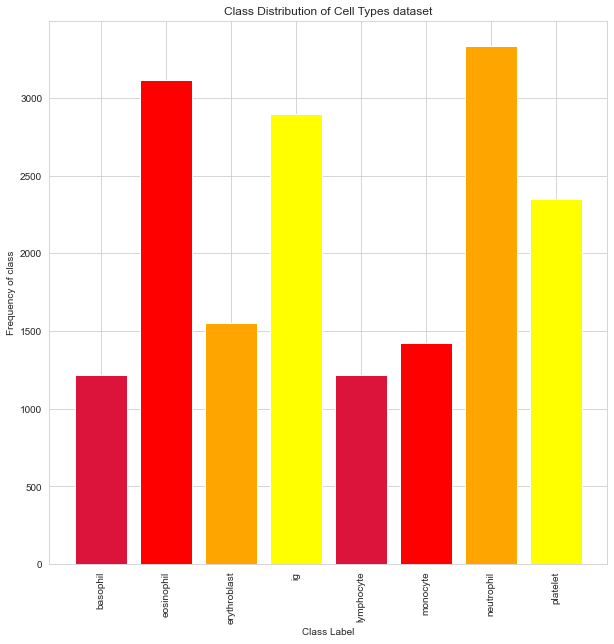

In [10]:
cell_type.class_distribution()

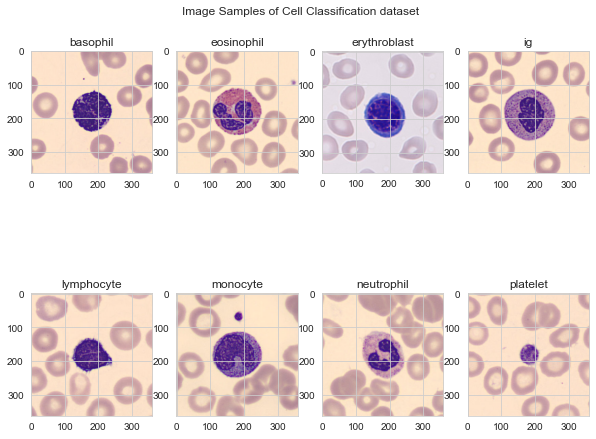

In [11]:
cell_type.show_samples()

In [12]:
cell_type.test_train_validation_split()

Copying files: 17092 files [02:26, 116.43 files/s]


# Image Processing

In [14]:
class ImageProcessor:

    def __init__(self, PARENT_DIR : str):
        self.TRAIN_DIR = os.path.join(PARENT_DIR, "train")
        self.VAL_DIR = os.path.join(PARENT_DIR, "val")
        self.TEST_DIR = os.path.join(PARENT_DIR, "test")
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None

    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )

    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training'
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=(75, 75),
            color_mode='rgb',
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

## Image Pre-processing

In [15]:
img_pre = ImageProcessor("../data/bloods-cells-splitted")

In [16]:
img_pre.create_generators()

In [18]:
train, val, test = img_pre.get_images()

Found 13671 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.


# Model Building

In [26]:
class ModelBuilder:

    def __init__(self, train, val):
        self.train = train
        self.val = val
        self.model = None
        self.history = None
    
    def __load_model(self):
        self.model = ResNet50(weights = 'imagenet', 
                              include_top = False, 
                              input_shape = (75,75,3))
    
    def __mark_layers_non_trainable(self):
        for layer in self.model.layers:
            layer.trainable = False
    
    def __add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(8, activation = 'softmax')(self.x)

    def design_model(self):
        self.__load_model()
        self.__mark_layers_non_trainable()
        self.__add_final_layer()

    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

    def fit_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=10, validation_data=self.val)

    def visualize_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])

In [27]:
resnet50 = ModelBuilder(train, val)

In [28]:
resnet50.design_model()

In [29]:
resnet50.compile_model()

In [30]:
resnet50.fit_model()

Epoch 1/10
428/428 [==============================] - 273s 624ms/step - loss: 1.7276 - accuracy: 0.7290 - val_loss: 0.6260 - val_accuracy: 0.8070
Epoch 2/10
428/428 [==============================] - 258s 602ms/step - loss: 0.4008 - accuracy: 0.8569 - val_loss: 0.5732 - val_accuracy: 0.8147
Epoch 3/10
428/428 [==============================] - 259s 605ms/step - loss: 0.2822 - accuracy: 0.8966 - val_loss: 0.4874 - val_accuracy: 0.8452
Epoch 4/10
428/428 [==============================] - 252s 589ms/step - loss: 0.2199 - accuracy: 0.9207 - val_loss: 0.5211 - val_accuracy: 0.8375
Epoch 5/10
428/428 [==============================] - 249s 581ms/step - loss: 0.1805 - accuracy: 0.9369 - val_loss: 0.4481 - val_accuracy: 0.8669
Epoch 6/10
428/428 [==============================] - 270s 632ms/step - loss: 0.1655 - accuracy: 0.9416 - val_loss: 0.5666 - val_accuracy: 0.8510
Epoch 7/10
428/428 [==============================] - 251s 587ms/step - loss: 0.1402 - accuracy: 0.9497 - val_loss: 0.7947 -

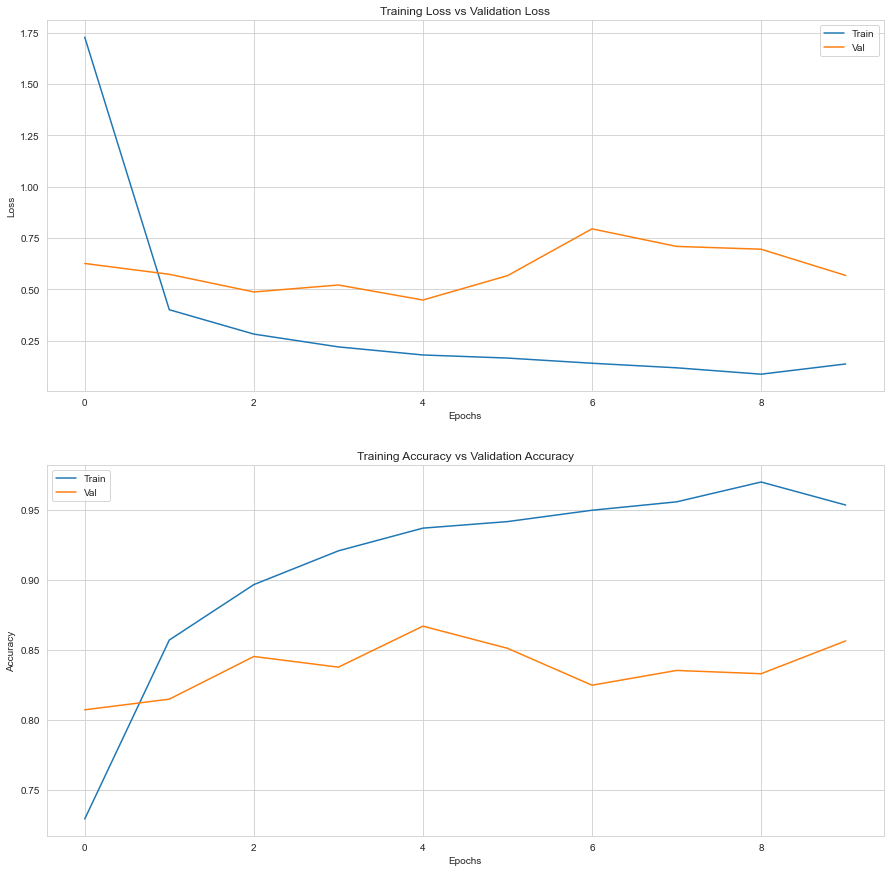

In [31]:
resnet50.visualize_history()

It is clearly observed that in the later epochs the model has started to get overfitted to the training data resulting in a bias and low variance. Hence, we need to use Early Stopping and Regularization techniques like Dropout to reduce the extent of overfitting.

## Model Evaluation

In [39]:
class ModelEvaluator:

    def __init__(self, base_model, train):
        self.model = base_model
        self.predictions = None
        self.CLASS_NAMES = list(train.class_indices.keys())
    
    def predict(self, test):
        self.predictions = np.argmax(self.model.predict(test), axis=1)

    def show_classification_report(self):
        acc = accuracy_score(test.labels, self.predictions)
        cm = tf.math.confusion_matrix(test.labels, self.predictions)
        clr = classification_report(test.labels, self.predictions, target_names=self.CLASS_NAMES)

        print("Test Accuracy: {:.3f}%".format(acc * 100))

        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
        plt.xticks(ticks= np.arange(8) + 0.5, labels=self.CLASS_NAMES, rotation=90)
        plt.yticks(ticks= np.arange(8) + 0.5, labels=self.CLASS_NAMES, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# Base model evaluation

In [40]:
evaluator = ModelEvaluator(resnet50.model, resnet50.train)

## Model predictions

In [41]:
evaluator.predict(test)

54/54 [==============================] - 25s 452ms/step


## Classification metrics

Test Accuracy: 86.946%


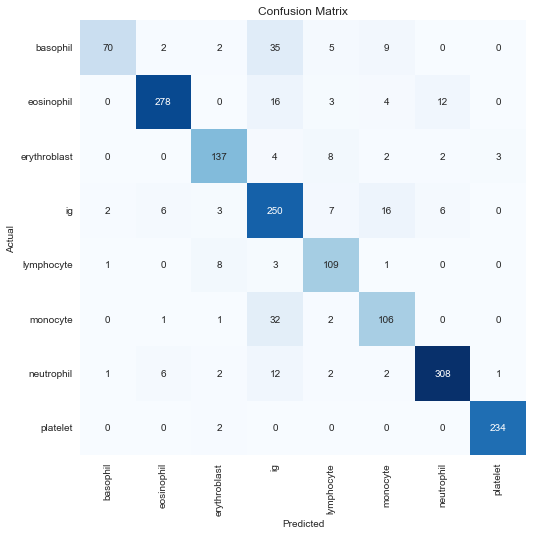

In [42]:
evaluator.show_classification_report()

# Conclusions